# Cardiovascular Disease

#### BRFSS Dataset
````The Behavioral Risk Factor Surveillance System (BRFSS) is the nation’s premier system of health-related telephone surveys that collect state data about U.S. residents regarding their health-related risk behaviors, chronic health conditions, and use of preventive services. ````

In [2]:
# Exploration
import pandas as pd
import numpy as np
import random

# Visualisation
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

# Préparation données
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, StratifiedKFold, cross_val_predict
from sklearn.model_selection import learning_curve
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score

# Modélisation
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

# imbalanced learning
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

###### -----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [3]:
data = pd.read_csv("./data/CVD_cleaned.csv")

In [4]:
data.head()

,General_Health,Checkup,Exercise,Heart_Disease,Skin_Cancer,Other_Cancer,Depression,Diabetes,Arthritis,Sex,Age_Category,Height_(cm),Weight_(kg),BMI,Smoking_History,Alcohol_Consumption,Fruit_Consumption,Green_Vegetables_Consumption,FriedPotato_Consumption
0,Poor,Within the past 2 years,No,No,No,No,No,No,Yes,Female,70-74,150.0,32.66,14.54,Yes,0.0,30.0,16.0,12.0
1,Very Good,Within the past year,No,Yes,No,No,No,Yes,No,Female,70-74,165.0,77.11,28.29,No,0.0,30.0,0.0,4.0
2,Very Good,Within the past year,Yes,No,No,No,No,Yes,No,Female,60-64,163.0,88.45,33.47,No,4.0,12.0,3.0,16.0
3,Poor,Within the past year,Yes,Yes,No,No,No,Yes,No,Male,75-79,180.0,93.44,28.73,No,0.0,30.0,30.0,8.0
4,Good,Within the past year,No,No,No,No,No,No,No,Male,80+,191.0,88.45,24.37,Yes,0.0,8.0,4.0,0.0


In [19]:
def check_null_empty_values(dataframe_name):
    '''
    Permet de vérifier la présence de valeur vide ou non assignée dans un dataframe !
    '''
    count = 0
    for colonne in dataframe_name.columns:
        count += len(dataframe_name[(dataframe_name[colonne].isnull() | dataframe_name[colonne].isna() | dataframe_name[colonne]=='')])
        
    if count == 0:
        print("Aucune valeur null / NA n'a été détectée !")
    else:
        raise Exception("Des valeurs manquantes ont été détectées dans le dataframe !")

In [20]:
def generate_color_palette(size):
    '''
    Permet de générer un nombre aléatoire entre 0 et 2^24, puis converti ce nombre en nombre hexadécimale afin
    de générer une couleur aléatoire.
    '''
    color_palette = []
    for i in range(size):
        couleur = ["#"+''.join([random.choice('ABCDEF0123456789') for j in range(6)])]
        color_palette.append(couleur[0])
    return color_palette

In [6]:
check_null_empty_values(data)

Aucune valeur null / NA n'a été détectée !


In [7]:
def show_column_repartition(dataframe,nom_colonne,titre=None,xlabel=None,ylabel=None):
    '''
    Permet de montrer la répartition des valeurs d'une colonne dans un bar plot
    '''
    x, y = np.unique(dataframe[nom_colonne], return_counts=True)
    color = mcolors.TABLEAU_COLORS
    color_list = []
    for key in color:
        color_list.append(key)
    couleurs = generate_color_palette(len(x))
    plt.figure(figsize=(12,8))
    if titre != None:
        plt.title(titre)
    plt.xticks(rotation=15, ha='right')
    plt.bar(list(x),list(y),label=list(x),color=couleurs,width=0.6,tick_label=x)
    if xlabel != None and ylabel != None:
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
    plt.show()

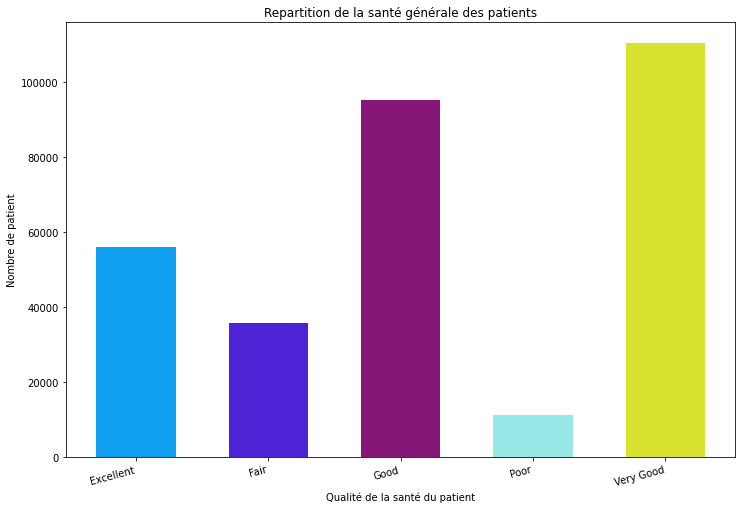

In [8]:
show_column_repartition(data,'General_Health',"Repartition de la santé générale des patients", "Qualité de la santé du patient", "Nombre de patient")

On peut montrer la répartition des valeurs des colonnes intéressantes afin d'analyser la répartition des valeurs mais également les potentiels actions à réaliser d'un point de vu "data processing" en terme de nettoyage des valeurs ou transformation en valeur numérique. Par exemple, la colonne "Sex" va être transformé en 1 et 0 afin de faciliter son utilisation dans les modèles de machine learning.

La fonction réalisée ci-dessous ``show_column_repartition`` va permettre de pousser l'analyse sur une colonne en particulier si nécessaire

In [9]:
couleurs = generate_color_palette(60)

In [10]:
def show_columns_details(dataframe,liste_colonnes,palette_couleurs):
    '''
    Permet d'afficher un bar plot montrant la répartition des valeurs au sein des colonnes
    Cette fonction prend en paramètre le dataframe pandas avec les différentes données, ainsi que la liste des colonnnes
    à analyser et également une palette de couleur permettant d'afficher les différents graphiques.
    La palette est une liste de valeur en héxadécimal faisant référence à des couleurs.
    Il est possible d'utiliser la fonction "generate_color_palette" afin de générer une palette de couleurs.
    '''
    n = len(liste_colonnes)
    plt.figure(figsize=(2*n,4*n))
    data_copy = dataframe[liste_colonnes]
    for i in range(n):
        if (n % 2)==0:
            plt.subplot((n//2), 2,(i+1))
        else:
            plt.subplot((n//2)+1, 2,(i+1))
        plt.bar(data_copy.iloc[:,i].value_counts().index,data_copy.iloc[:,i].value_counts().values,color=palette_couleurs)
        plt.title(f"Répartition des valeurs de la colonne {liste_colonnes[i]}")
        plt.xticks(rotation=15, ha='right')
    plt.show

In [11]:
colonnes_selectionnees = ['General_Health','Checkup','Heart_Disease','Exercise','Skin_Cancer','Other_Cancer','Depression','Sex','Age_Category','Diabetes','Arthritis']

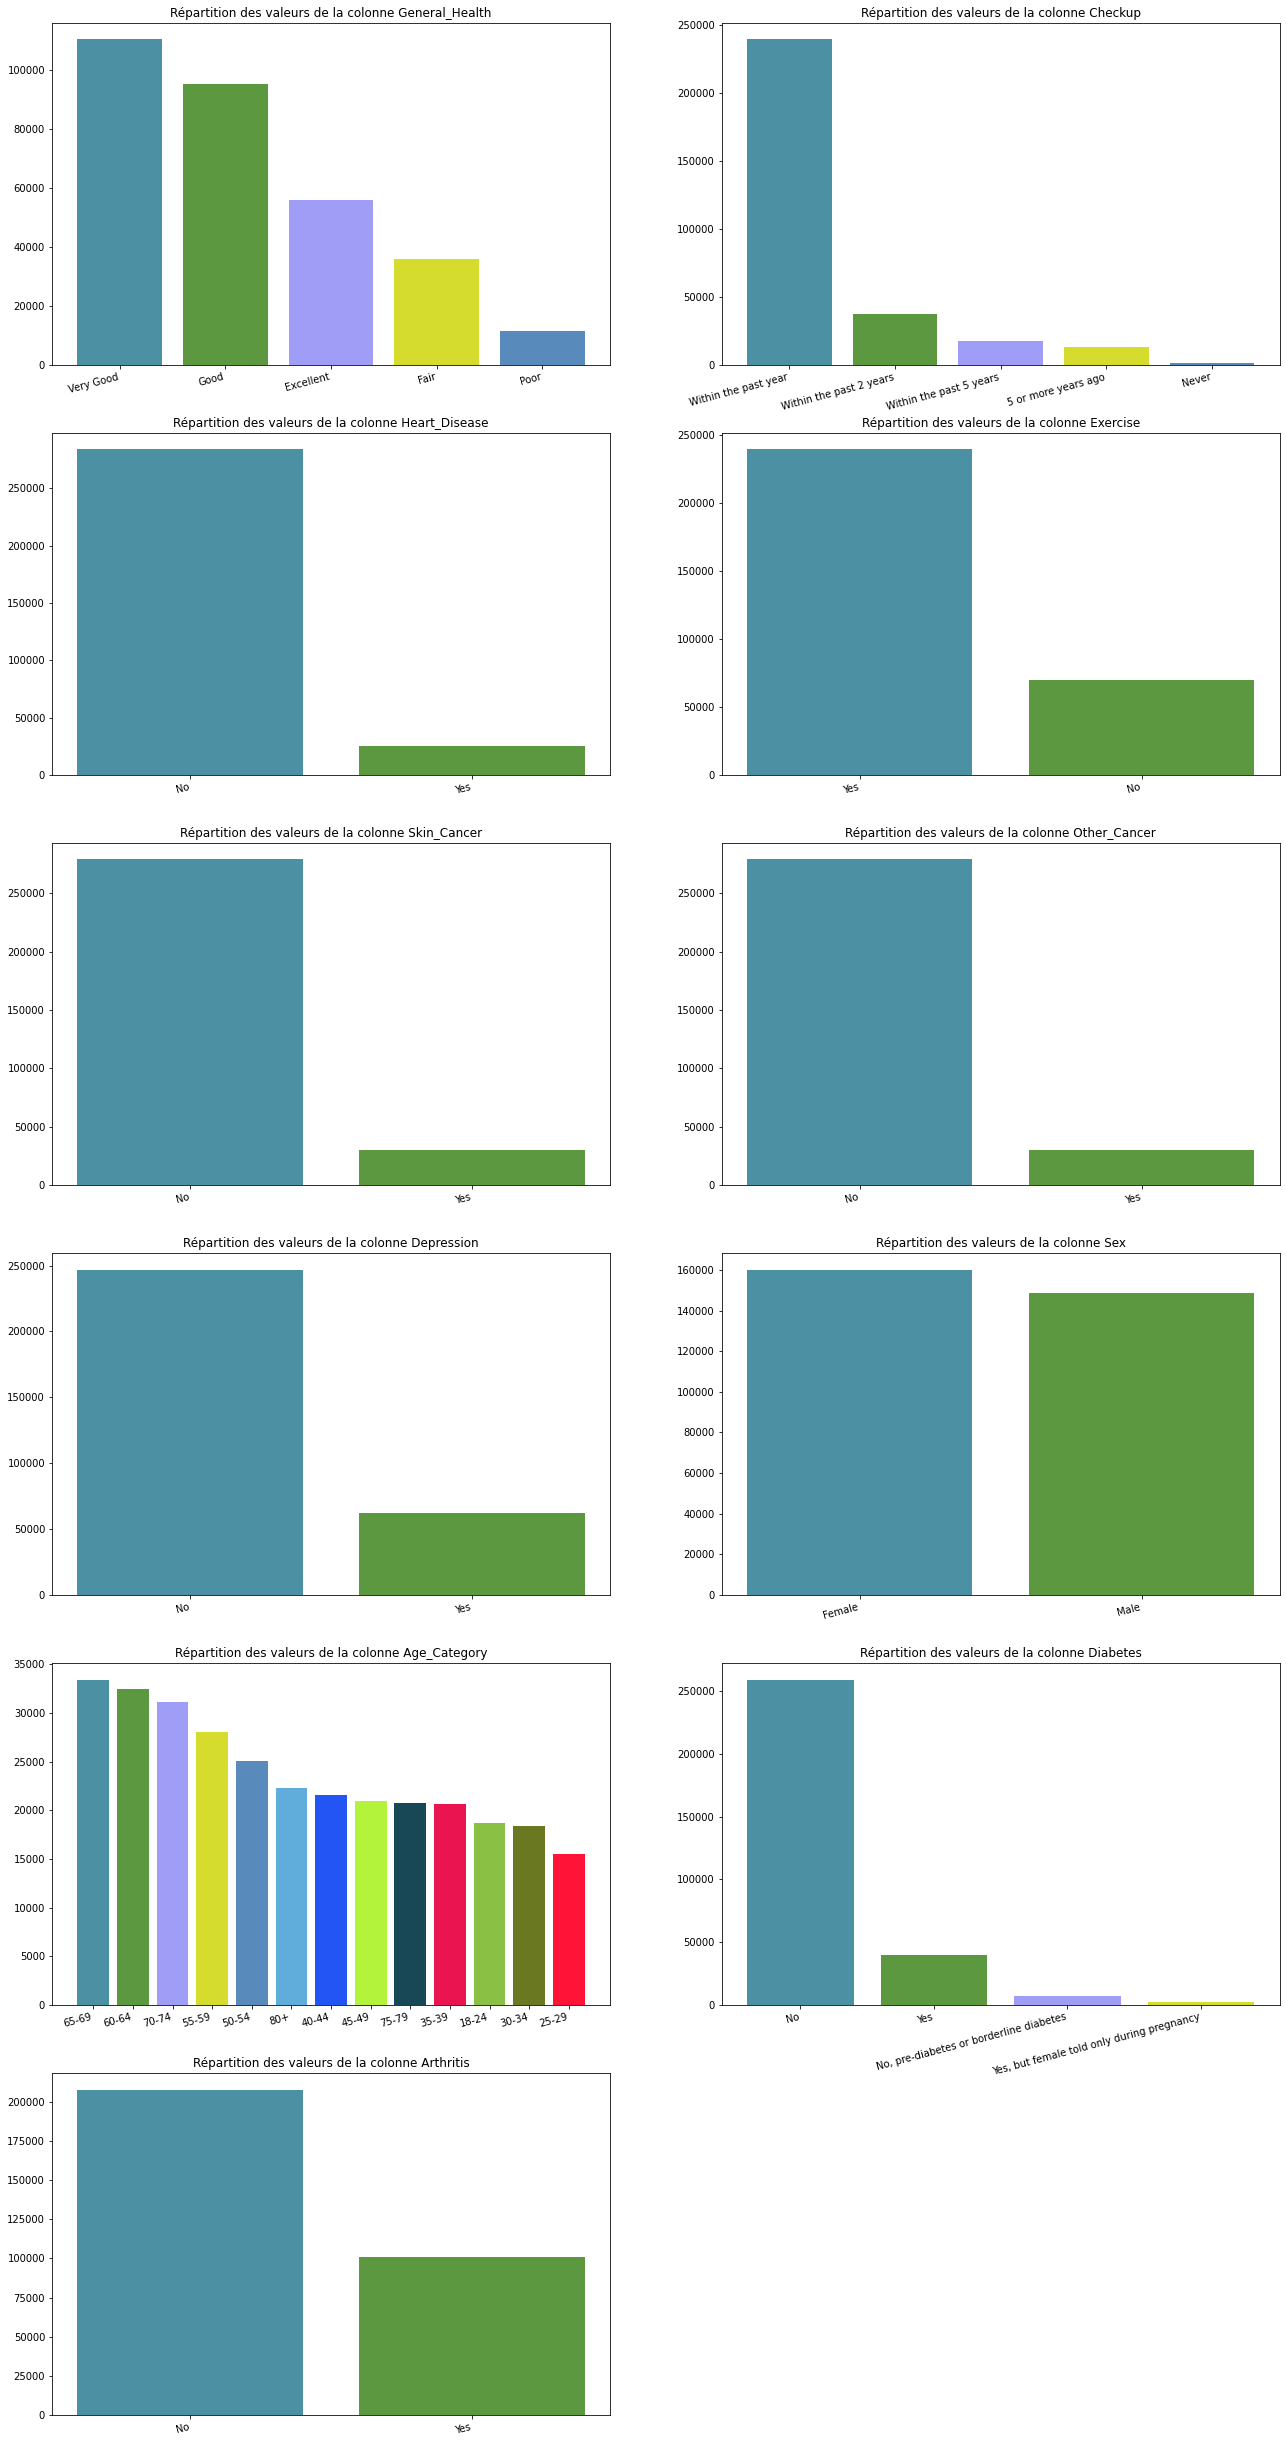

In [12]:
show_columns_details(data,colonnes_selectionnees,couleurs)

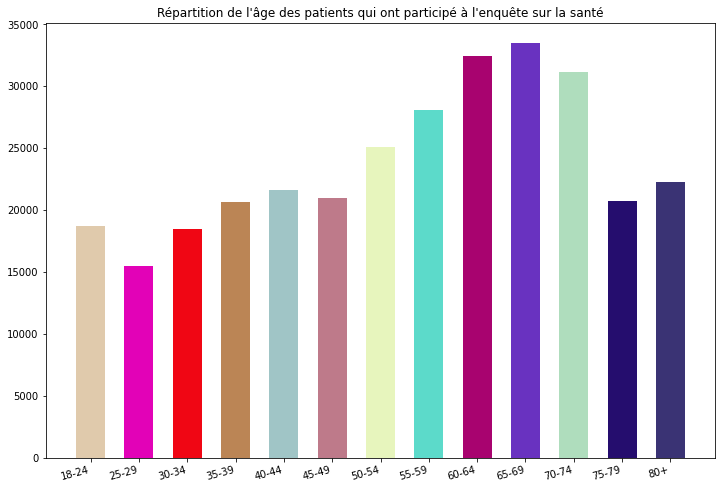

In [13]:
show_column_repartition(data,'Age_Category',"Répartition de l'âge des patients qui ont participé à l'enquête sur la santé")

# Data Pre-processing

Beaucoup de colonne possède des valeurs "Yes" ou "No", pour faciliter l'utilisation de ces colonnes dans les algorithmes de ``machine learning`` il faut encoder ces valeurs en 0 ou 1

La colonne "Diabetes" ne contient pas seulement des valeurs "Yes" ou "No" mais peut également contenir un détail supplémentaire comme par exemple "Yes, but female told only during pregnancy". Pour faciliter le traitement de ces informations par les algorithmes de machine learning, nous allons convertir cette donnée en simplement "Yes" ou "No"

Il faut également transformer les colonnes "General_health" et "Checkup" avec des valeurs numériques pour faciliter leurs utilisations

In [5]:
def preprocessed_data_column(data):
    '''
    Permet de remplacer les colonnes "textes" en valeur 0 ou 1 qui seront plus simples à interpréter
    par les algorithmes de Machine Learning.
    '''
    data['Sex'] = data['Sex'].map({'Female':0,'Male':1})
    data['Diabetes'] = data.Diabetes.str.replace(r'Yes.*', 'Yes',regex=True)
    data['Diabetes'] = data.Diabetes.str.replace(r'No.*', 'No',regex=True)
    cols_yes_no = ['Depression','Arthritis','Diabetes','Skin_Cancer','Heart_Disease','Other_Cancer','Exercise','Smoking_History']
    for col in cols_yes_no:
        data[col] = data[col].map({'No':0,'Yes':1})
    colonne_cat = ['Checkup','General_Health']
    for col in colonne_cat:
        data[col] = data[col].astype('category').cat.codes
    return data

In [6]:
data = preprocessed_data_column(data)

In [7]:
data.head()

,General_Health,Checkup,Exercise,Heart_Disease,Skin_Cancer,Other_Cancer,Depression,Diabetes,Arthritis,Sex,Age_Category,Height_(cm),Weight_(kg),BMI,Smoking_History,Alcohol_Consumption,Fruit_Consumption,Green_Vegetables_Consumption,FriedPotato_Consumption
0,3,2,0,0,0,0,0,0,1,0,70-74,150.0,32.66,14.54,1,0.0,30.0,16.0,12.0
1,4,4,0,1,0,0,0,1,0,0,70-74,165.0,77.11,28.29,0,0.0,30.0,0.0,4.0
2,4,4,1,0,0,0,0,1,0,0,60-64,163.0,88.45,33.47,0,4.0,12.0,3.0,16.0
3,3,4,1,1,0,0,0,1,0,1,75-79,180.0,93.44,28.73,0,0.0,30.0,30.0,8.0
4,2,4,0,0,0,0,0,0,0,1,80+,191.0,88.45,24.37,1,0.0,8.0,4.0,0.0


Nous pouvons vérifier le résultat via la fonction ``"show columns details"`` qui a été créée précédemment

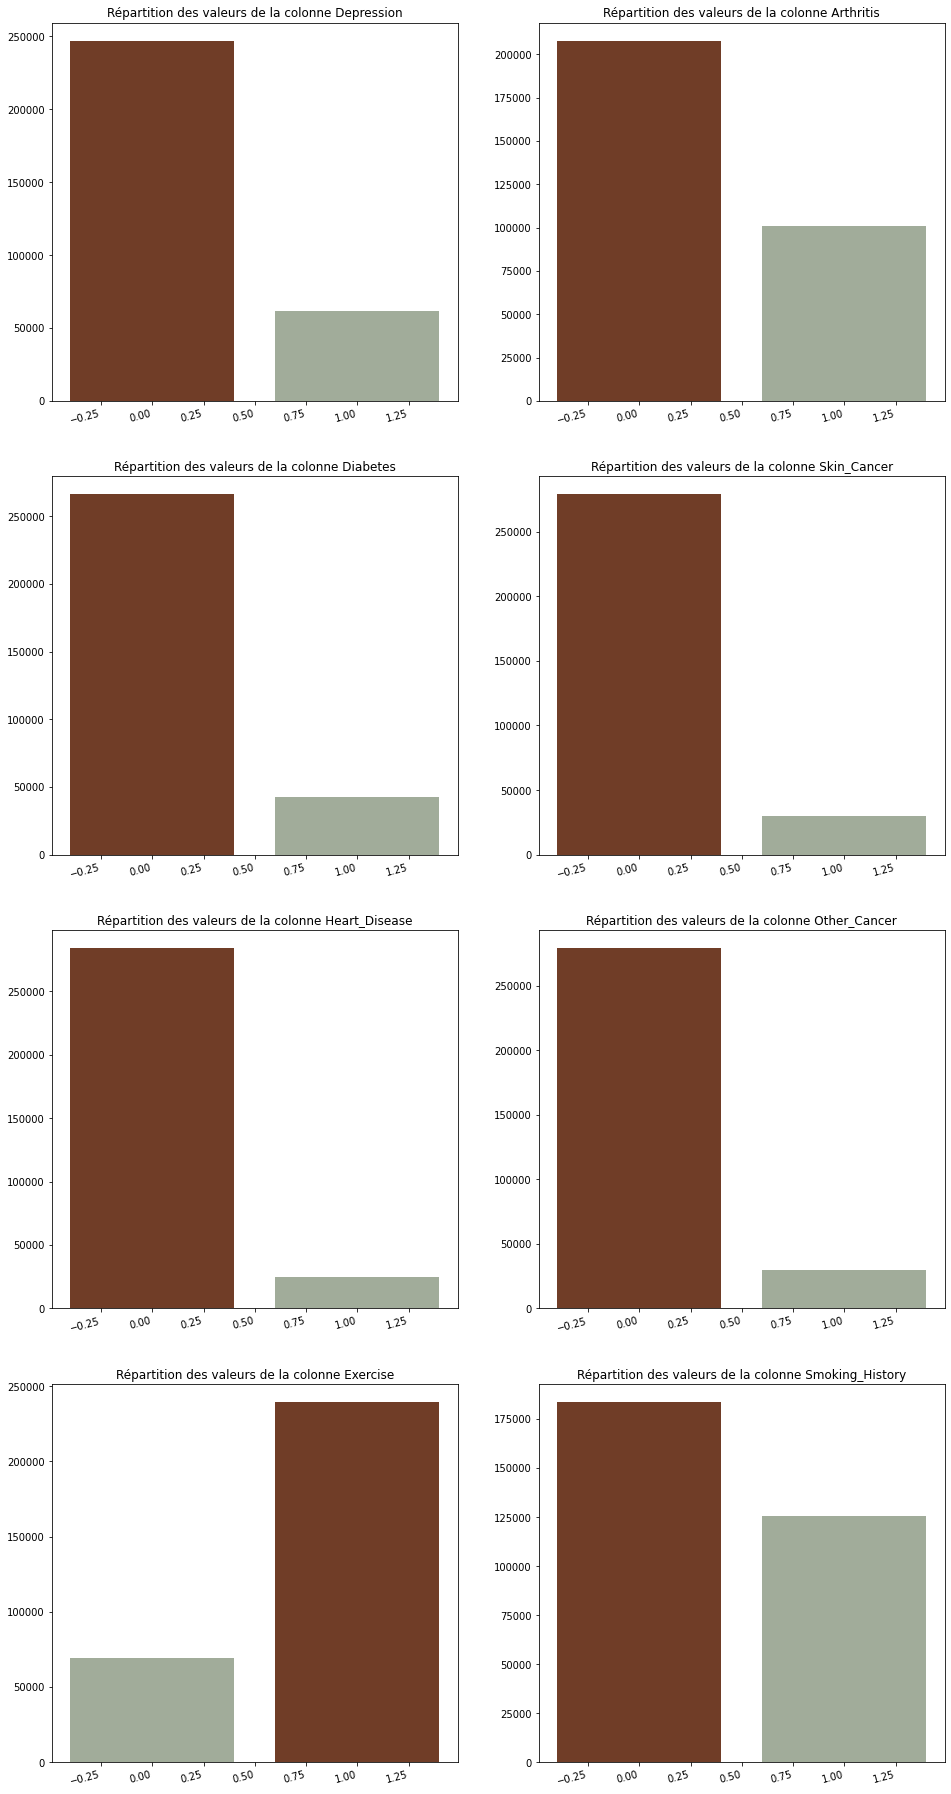

In [18]:
show_columns_details(data,cols_yes_no,couleurs)

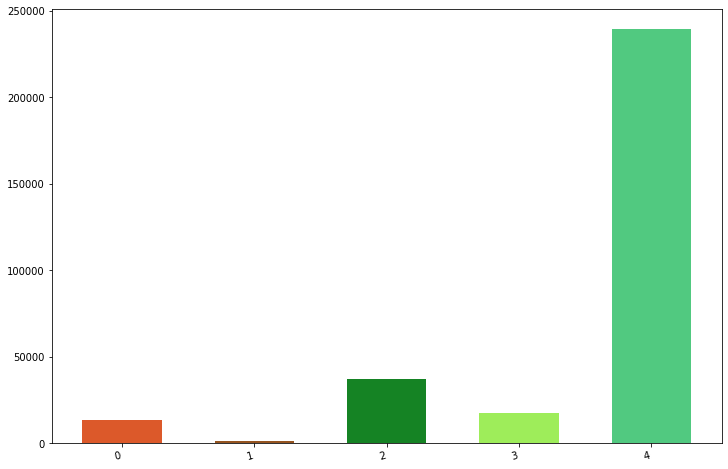

In [21]:
show_column_repartition(data,'Checkup')

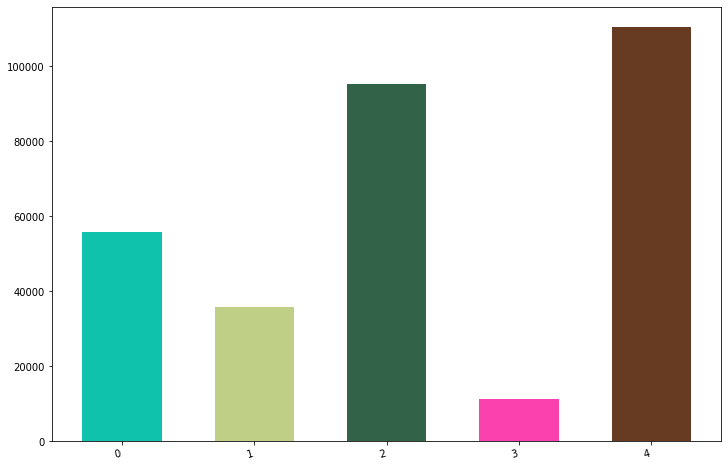

In [22]:
show_column_repartition(data,'General_Health')

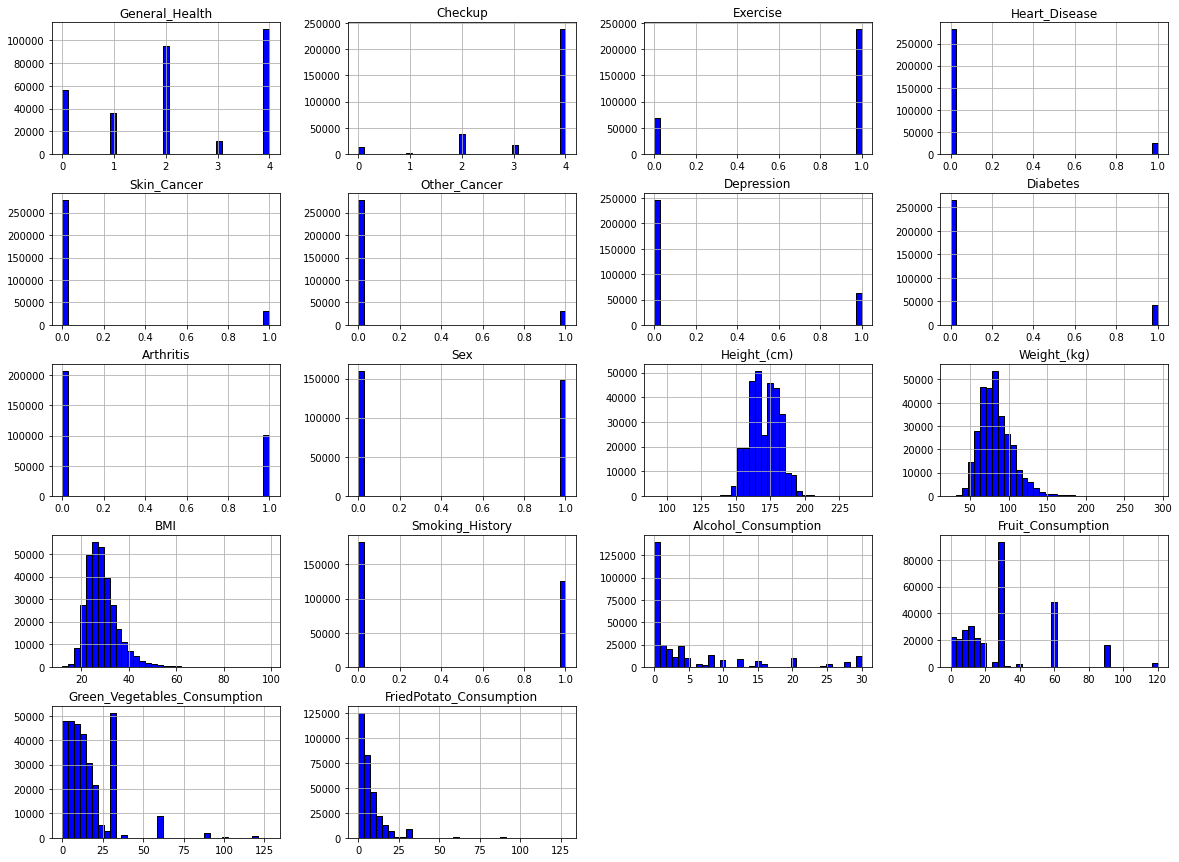

In [23]:
data.hist(bins=35, figsize=(20,15), color='blue',edgecolor='black')
plt.show()

In [8]:
age_intervalle = data['Age_Category'].unique().tolist()

In [9]:
def replace_age_interval(data):
    '''
    Nos données possèdent une donnée "Age Category" qui correspond à des tranches d'âge.
    Si une tranche d'âge a été indiqué et non l'âge exact, c'est très certainement dans un objectif "d'anonymiser" la donnée.
    Nos algorithmes ne vont pas bien traiter ces intervalles, il faut donc effectuer une transformation de la donnée.
    Il est possible d'effectuer une transformation par minimum, maximum ou une moyenne des valeurs de l'intervalle.
    Dans notre cas, nous allons utiliser le minimum puisque l'intervalle correspondant à l'age max est "80+".
    Il serait donc trop compliqué de faire une moyenne ou d'utiliser un maximum.
    '''
    age_replacement = [70,60,75,80,65,50,45,18,30,55,35,40,25]
    data['Age'] = data['Age_Category'].replace(age_intervalle,age_replacement)
    data.drop(columns='Age_Category',inplace=True)
    return data

In [10]:
data = replace_age_interval(data)

In [11]:
data.head()

,General_Health,Checkup,Exercise,Heart_Disease,Skin_Cancer,Other_Cancer,Depression,Diabetes,Arthritis,Sex,Height_(cm),Weight_(kg),BMI,Smoking_History,Alcohol_Consumption,Fruit_Consumption,Green_Vegetables_Consumption,FriedPotato_Consumption,Age
0,3,2,0,0,0,0,0,0,1,0,150.0,32.66,14.54,1,0.0,30.0,16.0,12.0,70
1,4,4,0,1,0,0,0,1,0,0,165.0,77.11,28.29,0,0.0,30.0,0.0,4.0,70
2,4,4,1,0,0,0,0,1,0,0,163.0,88.45,33.47,0,4.0,12.0,3.0,16.0,60
3,3,4,1,1,0,0,0,1,0,1,180.0,93.44,28.73,0,0.0,30.0,30.0,8.0,75
4,2,4,0,0,0,0,0,0,0,1,191.0,88.45,24.37,1,0.0,8.0,4.0,0.0,80


### Modélisation

In [12]:
random_forest = RandomForestClassifier(random_state=12)
gradient_boosting = GradientBoostingClassifier(random_state=12)
xgboost = XGBClassifier()

In [13]:
target = data['Heart_Disease']
features = data.drop(columns='Heart_Disease')

In [14]:
data.shape

(308854, 19)

Nous utilisions ici un ``"StratifiedKFold"`` pour essayer de se prévenir des problèmes de répartition des classes. En effet, notre target value "Heart_Disease" est très mal équilibré. La proportion est proche de 85% / 15% ce qui est très mauvais.

In [31]:
StratKFold = StratifiedKFold(n_splits=5,shuffle=True)

In [34]:
# Random Forest
accurracy_rf = cross_val_score(random_forest,features,target,cv=StratKFold,scoring='accuracy')
print("Accuracy Random Forest : " + str(accurracy_rf))
recall_rf = cross_val_score(random_forest,features,target,cv=StratKFold,scoring='recall')
print("Recall Random Forest : " + str(recall_rf))

Accuracy Random Forest : [0.91839213 0.91881304 0.91892636 0.91882922 0.91873078]
Recall Random Forest : [0.02803364 0.0298358  0.02963556 0.02902903 0.03163797]


In [36]:
# Gradient Boosting
accurracy_gradboost = cross_val_score(gradient_boosting,features,target,cv=StratKFold,scoring='accuracy')
print("Accuracy Gradient Boosting : " + str(accurracy_gradboost))
recall_gradboost = cross_val_score(gradient_boosting,features,target,cv=StratKFold,scoring='recall')
print("Recall Gradient Boosting : " + str(recall_gradboost))

Accuracy Gradient Boosting : [0.91955772 0.91954153 0.9198815  0.91968723 0.91942691]
Recall Gradient Boosting : [0.04485382 0.04405286 0.04144974 0.04404404 0.04665599]


In [37]:
# XGBoost
accurracy_xgboost = cross_val_score(xgboost,features,target,cv=StratKFold,scoring='accuracy')
print("Accuracy XGBoost : " + str(accurracy_xgboost))
recall_xgboost = cross_val_score(xgboost,features,target,cv=StratKFold,scoring='recall')
print("Recall XGBoost : " + str(recall_xgboost))

Accuracy XGBoost : [0.91829499 0.91884541 0.919153   0.91887779 0.91931358]
Recall XGBoost : [0.04825791 0.05546656 0.0526632  0.05405405 0.04885863]


On observe une très bonne accuracy mais qui est très fortement biaisé par l'équilibrage des données. On va procéder à upsampling et downsampling afin de voir son impact sur la performance du modèle

In [39]:
# Over Sampling
sm = SMOTE(random_state=12)
feature_os, target_os = sm.fit_resample(features,target)

In [40]:
# Under Sampling
us = RandomUnderSampler(random_state=12)
feature_us, target_us = us.fit_resample(features,target)

In [41]:
# Gradient Boosting Over Sampling
accurracy_gradboost = cross_val_score(gradient_boosting,feature_os,target_os,cv=StratKFold,scoring='accuracy')
print("Accuracy Gradient Boosting : " + str(accurracy_gradboost))
recall_gradboost = cross_val_score(gradient_boosting,feature_os,target_os,cv=StratKFold,scoring='recall')
print("Recall Gradient Boosting : " + str(recall_gradboost))

Accuracy Gradient Boosting : [0.88155415 0.88150027 0.88054917 0.88207269 0.88611485]
Recall Gradient Boosting : [0.88512954 0.88902001 0.89014725 0.88657379 0.88773623]


In [42]:
# Gradient Boosting Under Sampling
accurracy_gradboost = cross_val_score(gradient_boosting,feature_us,target_us,cv=StratKFold,scoring='accuracy')
print("Accuracy Gradient Boosting : " + str(accurracy_gradboost))
recall_gradboost = cross_val_score(gradient_boosting,feature_us,target_us,cv=StratKFold,scoring='recall')
print("Recall Gradient Boosting : " + str(recall_gradboost))

Accuracy Gradient Boosting : [0.76073681 0.75693263 0.7634161  0.76061274 0.76752103]
Recall Gradient Boosting : [0.81057269 0.8        0.80236284 0.81417701 0.82138566]


In [43]:
# XGBoost Over Sampling
accurracy_xgboost = cross_val_score(xgboost,feature_os,target_os,cv=StratKFold,scoring='accuracy')
print("Accuracy XGBoost : " + str(accurracy_xgboost))
recall_xgboost = cross_val_score(xgboost,feature_os,target_os,cv=StratKFold,scoring='recall')
print("Recall XGBoost : " + str(recall_xgboost))

Accuracy XGBoost : [0.94901985 0.95039321 0.94918672 0.94936285 0.94793621]
Recall XGBoost : [0.91359177 0.91124771 0.9127096  0.91258784 0.913627  ]


In [64]:
# XGBoost Under Sampling
accurracy_xgboost = cross_val_score(xgboost,feature_us,target_us,cv=StratKFold,scoring='accuracy')
print("Accuracy XGBoost : " + str(accurracy_xgboost))
recall_xgboost = cross_val_score(xgboost,feature_us,target_us,cv=StratKFold,scoring='recall')
print("Recall XGBoost : " + str(recall_xgboost))

Accuracy XGBoost : [0.75693263 0.75002503 0.75941129 0.75410493 0.75060072]
Recall XGBoost : [0.79014818 0.80980981 0.7917501  0.78754505 0.79955947]


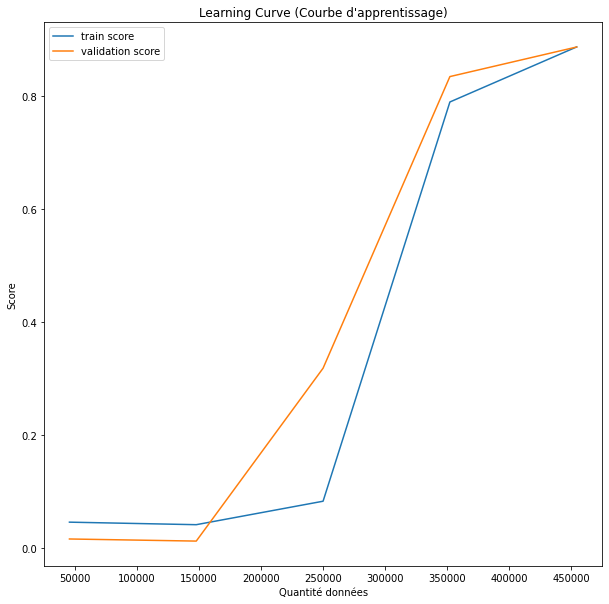

In [44]:
# Gradient Boosting
N, train_score, val_score = learning_curve(gradient_boosting, feature_os, target_os,cv=StratKFold,scoring='recall',random_state=26)
plt.figure(figsize=(10, 10))
plt.plot(N,train_score.mean(axis=1), label='train score')
plt.plot(N,val_score.mean(axis=1), label='validation score')
plt.ylabel('Score')
plt.xlabel('Quantité données')
plt.title("Learning Curve (Courbe d'apprentissage)")
plt.legend()

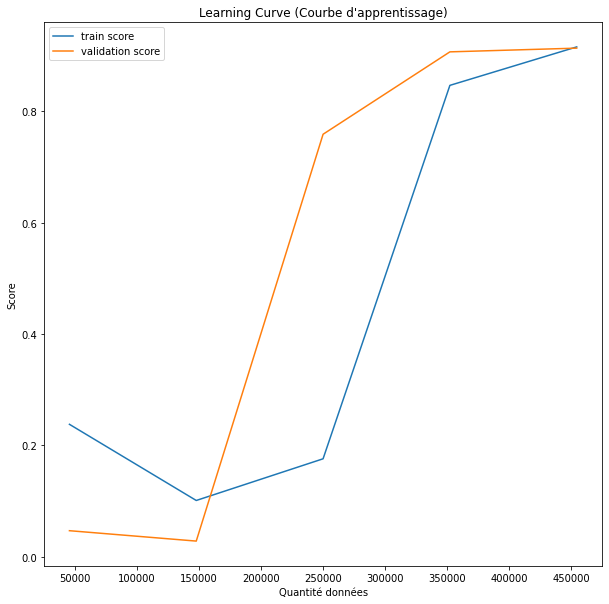

In [45]:
# XGBoost
N, train_score, val_score = learning_curve(xgboost, feature_os, target_os,cv=StratKFold,scoring='recall',random_state=26)
plt.figure(figsize=(10, 10))
plt.plot(N,train_score.mean(axis=1), label='train score')
plt.plot(N,val_score.mean(axis=1), label='validation score')
plt.ylabel('Score')
plt.xlabel('Quantité données')
plt.title("Learning Curve (Courbe d'apprentissage)")
plt.legend()

In [46]:
# Over sampling and Under Sampling
def over_and_under_sampling(features,target,os_sample_strategy,us_sample_strategy):
    '''
    Permet sur un jeu de donnée (features et target) de procéder à de l'over-sampling puis de l'under-sampling
    en renseignant une strategy d'over-sampling et d'under-sampling.
    Au lieu d'équilibrer à 100% les deux classes, permet d'adapter les deux classes (majoritaires et minoritaires)
    afin de se retrouver avec une proportion équilibrée.
    '''
    sm = SMOTE(sampling_strategy=os_sample_strategy)
    feature_os, target_os = sm.fit_resample(features,target)
    us = RandomUnderSampler(sampling_strategy=us_sample_strategy)
    feature_os_us, target_os_us = us.fit_resample(feature_os,target_os)
    return feature_os_us, target_os_us

In [47]:
xgboost_grid = {'eta': [0.01,0.1], 'max_depth': [3,6]}

In [48]:
best_param = GridSearchCV(xgboost,xgboost_grid, scoring='roc_auc', cv=StratKFold)

In [49]:
best_param.fit(feature_os,target_os)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_t...
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, ...),
             param_grid={'eta': [0.01, 0.1], 'max_depth': [3, 6]},
             scoring='roc_auc')

In [50]:
best_param.best_params_

{'eta': 0.1, 'max_depth': 6}

In [51]:
model_xgboost = XGBClassifier(eta=0.1,max_depth=6)

In [52]:
model_xgboost.fit(feature_os,target_os)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.1, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

In [53]:
X_train, X_test, y_train, y_test = train_test_split(feature_os,target_os,test_size=0.3,random_state=26)

In [54]:
model_xgboost.fit(X_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.1, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

In [55]:
def evaluation_model(model,features,target):
    '''
    '''
    X_train, X_test, y_train, y_test = train_test_split(features,target,test_size=0.3,random_state=26)
    model.fit(X_train,y_train)
    ypred = model.predict(X_test)
    ypred_proba = model.predict_proba(X_test)
#     print("La matrice de confusion : \n" + str(confusion_matrix(y_test,ypred))+ "\n")
    print("Reporting de prédiction : \n" + str(classification_report(y_test,ypred))+ "\n")
    cf_matrix = confusion_matrix(y_test,ypred)
    plt.figure(figsize=(10, 10))
    plt.subplot(2,1,1)
    sns.heatmap(cf_matrix, annot=True,fmt=".1f", cmap='Blues')
    false_positive_rate, true_positive_rate, seuil = roc_curve(y_test,ypred_proba[:, 1])
    auc = roc_auc_score(y_test,ypred_proba[:, 1])
    plt.subplot(2,1,2)
    plt.plot(false_positive_rate,true_positive_rate,label="AUC="+str(auc))
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.title("Courbe ROC")
    plt.legend(loc=4)
    plt.show()
    pd.DataFrame(model.feature_importances_,index=X_test.columns,columns=['feature_imp']).sort_values(by='feature_imp', ascending=False).plot.bar(color='green',figsize=(10,8))

Reporting de prédiction : 
              precision    recall  f1-score   support

           0       0.91      0.95      0.93     85178
           1       0.95      0.91      0.93     85152

    accuracy                           0.93    170330
   macro avg       0.93      0.93      0.93    170330
weighted avg       0.93      0.93      0.93    170330




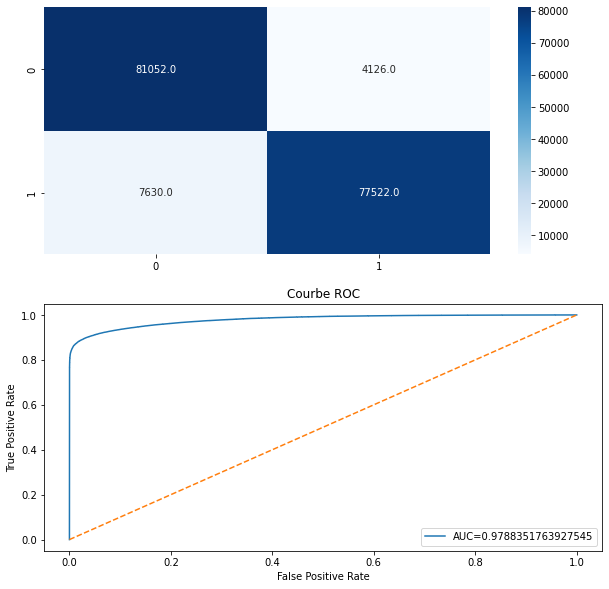

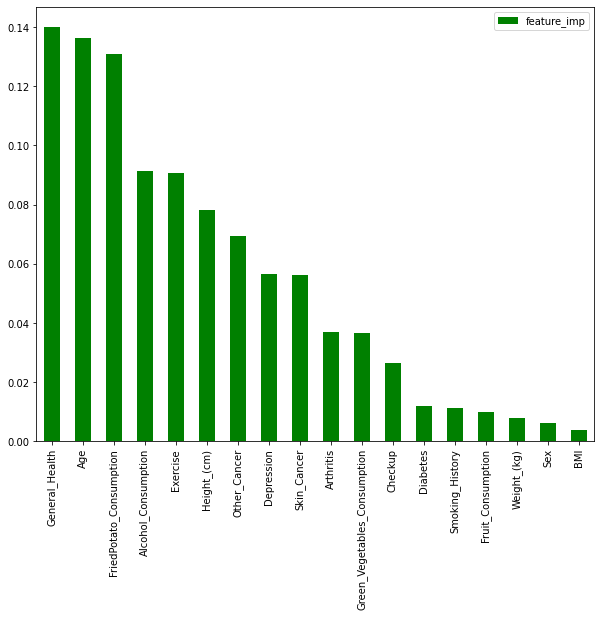

In [56]:
evaluation_model(model_xgboost,feature_os,target_os)

L'over-sampling avec SMOTE se base sur la création de nouveau point par rapport au "k nearest neighbors". Par défaut, cette valeur est à 5 voisins. Il est intéressant de faire varier cette valeur de k et d'observer la performance de notre meilleur modèle (sans tuning pour le moment) afin de prendre la meilleure valeur de "k" pour notre tâche d'over-sampling. A partir de k=15, on voit seulement une très légère augmentation de la valeur du ROC AUC. On prend toujours la meilleure mais toutes les valeurs exécutées ci-dessous reste tout à fait convenable.

In [67]:
k_values = [15,18,20,25,30]
for k in k_values:
    sm = SMOTE(k_neighbors=k)
    feature_os, target_os = sm.fit_resample(features,target)
    scores = cross_val_score(xgboost,feature_os,target_os,cv=StratKFold,scoring='roc_auc')
    score_moyen = np.mean(scores)
    print(f"k={k} ROC AUC Moyen : {score_moyen}")

k=15 ROC AUC Moyen : 0.984005716972265
k=18 ROC AUC Moyen : 0.984137745882645
k=20 ROC AUC Moyen : 0.9841648430773315
k=25 ROC AUC Moyen : 0.9842096570018235
k=30 ROC AUC Moyen : 0.984342487829535


Après avoir trouvé la bonne valeur de "k" pour l'étape d'over-sampling, il est important de repasser un GridSearch afin de trouver de nouveau les meilleurs paramètres de notre modèle (xgboost).

In [68]:
sm = SMOTE(k_neighbors=30)
feature_os, target_os = sm.fit_resample(features,target)
xgboost_grid = {'eta': [0.01,0.1], 'max_depth': [3,6,8,10]}
best_param = GridSearchCV(xgboost,xgboost_grid, scoring='roc_auc', cv=StratKFold)
best_param.fit(feature_os,target_os)
best_param.best_params_

{'eta': 0.1, 'max_depth': 10}

In [69]:
best_xgboost = XGBClassifier(eta=0.1, max_depth=10)

Reporting de prédiction : 
              precision    recall  f1-score   support

           0       0.92      0.99      0.95     85178
           1       0.98      0.91      0.95     85152

    accuracy                           0.95    170330
   macro avg       0.95      0.95      0.95    170330
weighted avg       0.95      0.95      0.95    170330




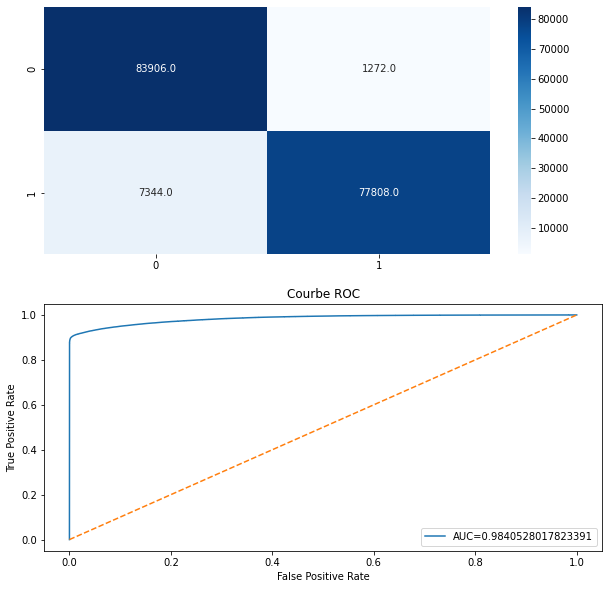

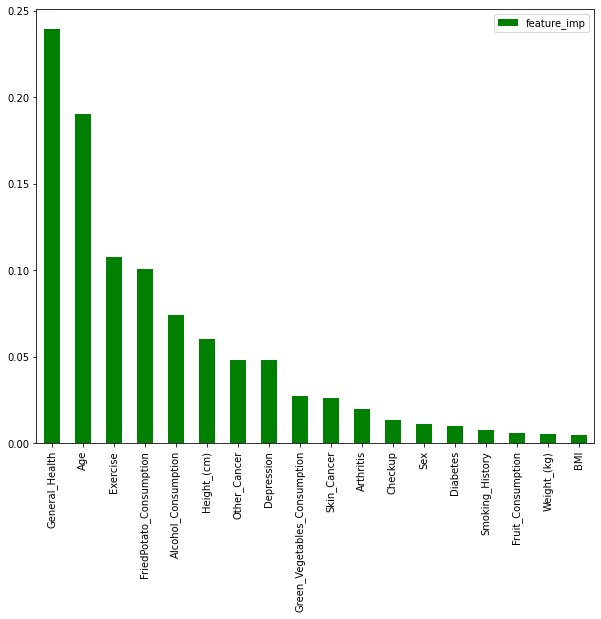

In [70]:
evaluation_model(best_xgboost,feature_os,target_os)

Le modèle prédictif qui est présenté permet de définir si un patient est susceptible de développer une maladie cardiovasculaire en fonction des différents champs d'entrées présents dans notre dataset.
Les caractéristiques impactants le plus notre modèle sont : 
- la santé "générale" du patient : (Poor, Fair, Good, Very Good, Excellent) 
- l'âge du patient
- sa pratique d'exercice physique
- sa consommation de frites de pomme de terre (on peut inclure de manière général, les aliments frits)
- sa consommation d'alcool

Les autres caractéristiques impactent plus faiblement le modèle. 